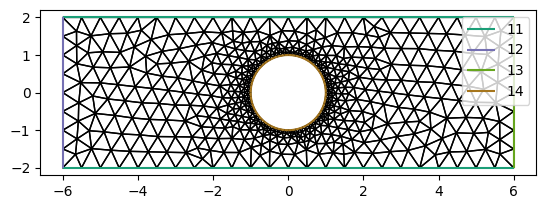

In [1]:
from firedrake import *
from firedrake.__future__ import interpolate
import matplotlib.pyplot as plt
from matplotlib import rc
import ufl

N = 64

M = Mesh('immersed_domain.msh')

def plot_mesh(mesh):
    fig, axes = plt.subplots()
    triplot(mesh, axes=axes)
    plt.gca().set_aspect('equal', adjustable='box')
    axes.legend()

plot_mesh(M)


V = VectorFunctionSpace(M, "CG", 2)
W = FunctionSpace(M, "CG", 1)

In [2]:
Z = V * W

up = Function(Z)
u, p = split(up)
v, q = TestFunctions(Z)

Re = Constant(10.0)

F = 1.0 / Re * inner(grad(u), grad(v)) * dx - p * div(v) * dx + div(u) * q * dx

In [3]:
x, y = SpatialCoordinate(M)
u_inflow = as_vector([((y+2)*(4-(y+2))/2.0)*10**(-2), 0]) # add *10^-2 to lower perchelt number
bcs = [
    DirichletBC(Z.sub(0), assemble(interpolate(u_inflow, V)), 12),
    DirichletBC(Z.sub(0), Constant((0, 0)), (11, 14))
]

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


  0 SNES Function norm 1.982032490452e-02
  1 SNES Function norm 2.114237481854e-16


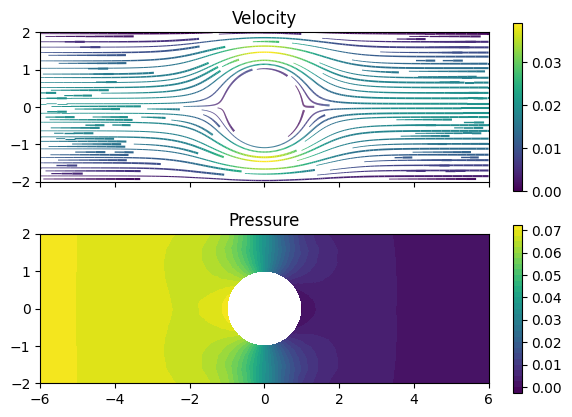

In [4]:
nullspace = MixedVectorSpaceBasis(Z, [Z.sub(0), VectorSpaceBasis(constant=True)])

solve(
    F == 0,
    up,
    bcs=bcs,
#    nullspace=nullspace,
    solver_parameters={
        "snes_monitor": None,
    },
)

u_init, p_init = up.subfunctions

fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
streamlines = streamplot(u_init, resolution=0.1,  seed=0, axes=axes[0])
fig.colorbar(streamlines, ax=axes[0], fraction=0.046)
axes[0].set_aspect("equal")
axes[0].set_title("Velocity")

contours = tricontourf(p_init, 30, axes=axes[1])
fig.colorbar(contours, ax=axes[1], fraction=0.046)
axes[1].set_aspect("equal")
axes[1].set_title("Pressure");

u_file = VTKFile("velocity_gmsh.pvd")
p_file = VTKFile("pressure_gmsh.pvd")

u_file.write(u_init)
p_file.write(p_init)



In [5]:
# Mesh definition
use_quad_mesh = False
number_of_elements_x = 25
number_of_elements_y = 25
square_mesh = UnitSquareMesh(number_of_elements_x, number_of_elements_y, quadrilateral=use_quad_mesh)

In [6]:
# Continuous Galerkin function space (degree = 1)
p = 2
V = FunctionSpace(M, "CG", p)
VelSpace = VectorFunctionSpace(M, "CG", p)

# Strong boundary conditions
u1, u2 = 0.0, 0.0
g_left = Constant(u1)
g_right = Constant(u2)
g_cylinder = Constant(1)

# Marking the boundaries
bc_left = DirichletBC(V, g_left, 12)
# bc_right = DirichletBC(V, g_right, 13)
bc_cylinder = DirichletBC(V, g_cylinder, 14)
dirichlet_condition = [bc_left, bc_cylinder]

In [7]:
# Source term
f = Constant(0)

# Getting trial and test functions
u = TrialFunction(V)
v = TestFunction(V)

# Model's parameters
k = Constant(1e-8)  # Diffusion
b = Function(VelSpace)
b.interpolate(as_vector([1.0, 0.0]))  # Advective velocity

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f4b7470fd60>, VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1)), 63)

In [8]:
# Bilinear form
a = k * inner(grad(v), grad(u))*dx + dot(b, grad(u)) * v * dx

# Linear form (RHS)
L = f * v * dx

In [9]:
# *** Adding residual stabilizing terms ***
# Stabilizing parameters (based on Franca et al. 1992)
if p == 1:
    m_k = 1.0 / 3.0
elif p == 2 and not use_quad_mesh:
    m_k = 1.0 / 12.
elif p == 2 and use_quad_mesh:
    m_k = 1.0 / 24.
else:
    raise ValueError("The employed mesh currently has no stabilization parameters available.")

# h_k = CellDiameter(mesh)
h_k = sqrt(2) * CellVolume(M) / CellDiameter(M)
# b_norm = norm(b)
b_norm = sqrt(dot(b, b))
Pe_k = m_k * b_norm * h_k / (2.0 * k)
one = Constant(1.0)
eps_k = conditional(gt(Pe_k, one), one, Pe_k)
tau_k = h_k / (2.0 * b_norm) * eps_k

# Residual stabilizing terms
a += inner((dot(b, grad(u)) - k*div(grad(u))), tau_k * dot(b, grad(v))) * dx
L += f * tau_k * dot(b, grad(v)) * dx

In [10]:
# Discretizing the variational problem
u_sol = Function(V)
problem = LinearVariationalProblem(a, L, u_sol, dirichlet_condition)

# Solving the discretized system
solver = LinearVariationalSolver(problem)
solver.solve()

# Writing solution to vtk file
output_pvd = VTKFile("result_supg/sol.pvd")
output_pvd.write(u_sol)

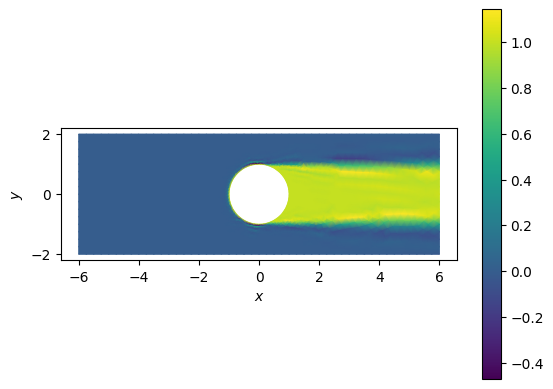

In [11]:
# Plotting the solution
colorplot = tripcolor(u_sol)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(colorplot)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

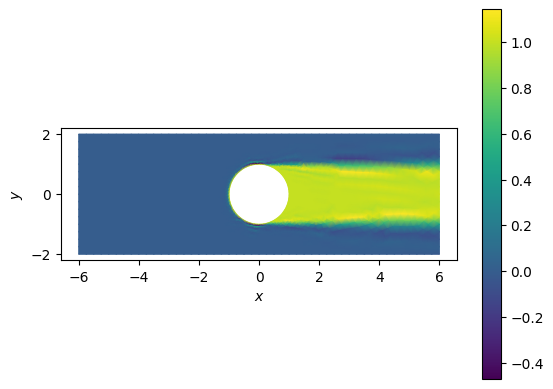

In [12]:
# Plotting the solution
colorplot = tripcolor(u_sol)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(colorplot)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()